# Spatial autocorrelation and Exploratory Spatial Data Analysis

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: *positive* spatial autocorrelation, when similar values tend to group together in similar locations; and *negative* spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

In this session we will learn how to explore spatial autocorrelation in a given dataset, interrogating the data about its presence, nature, and strength. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA), specifically designed for this purpose. The range of ESDA methods is very wide and spans from simpler approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze *global*, and *local* spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the degree of *clustering* in the dataset. *Do values generally follow a particular pattern in their geographical distribution*? *Are similar values closer to other similar values than we would expect from pure chance?* These are some of the questions that tools for global spatial autocorrelation allow to answer. We will practice with global spatial autocorrelation by using Moran's I statistic.

Tools for *local* spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique we will review in this session to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

**IMPORTANT**: the paths above might have look different in your computer. See [this introductory notebook](begin.html) for more details about how to set your paths.

## Data

For this session, we will use a classic dataset in the history of spatial analysis: the cholera map by Dr. John Snow. His story is well known: thanks to his mapping exercise of the location of cholera deaths in XIXth. Century London, he was able to prove that the disease is in fact transmitted through contaminated water (associated to a specific pump), as opposed to the conventional thinking of the day, which stated that transmission occured through the air. Our goal will be to support Snow's view with the help of ESDA tools.

Although the original data was locations of deaths at the point level, in this case we will access an aggregated version that reports cholera death counts at the street level. This will allow us to try calculating spatial weights matrices for a different but also very common type of data, lines. It is also the spatial unit at which the process we are looking is probably best characterized: since we do not have individual data on house units, but only the location of those who passed away, aggregating at a unit like the street segment provides a good approximation of the scale at which the disease was occuring and spreading. 

In addition, since the original data are raw counts, we should include a measure of the underlying population. Remember that if all one maps are the events of interest, unless the population is evenly distributed, the analysis will be biased because high counts could just be a reflection of a large underlying population (everything else equal, a street with more people will be more likely to have more cholera deaths). In the case of this example, the ideal variable would be to have a count of the inhabitants of each street. Unfortunately, these data are not available, so we need to find an approximation. This will inevitably imply making assumptions and, potentially, introduce certain degree of measurement error. For the sake of this example, we will assume that, within the area of central London covered by the data, population was evenly spread across the street network. This means that the underlying population of one of our street segments is proportional to its length. Following from this assumption, if we want to control for the underlying population of a street segment, a good approach could be to consider the number of cholera deaths per (100) metre(s) -a measure of density- rather than the raw count. It is important to remember that, to the extent the population was *not* entirely evenly distributed, this will introduce some error in the analysis, so conclusions should be drawn with caution if this was a real-world analysis. Since this is an example however, the results will suffice to learn how to interpret the output of a global and spatial autocorrelation exploratory analysis.

All the necessary data are available as a single download from the course website on the following link:

> [http://darribas.org/gds17/content/labs/data/john_snow.zip](http://darribas.org/gds17/content/labs/data/john_snow.zip)

The folder contains the street network, point data for the location of the pumps -one of which was contaminated with cholera- and a polygon file with building blocks from the Ordnance Survey (OS data © Crown copyright and database right, 2015). An explanation of the data sources is provided in the companion text file `README.txt`.

Once you download it and unpack it into your computer, set the path to its location as we have been doing on the previous sessions:

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
js_path = '../../../gds17_data/john_snow/'

**IMPORTANT**: the paths above might have look different in your computer. See [this introductory notebook](begin.html) for more details about how to set your paths.

### Loading and exploring the data

Although the data are lines instead polygons, we can load and manipulate them in exactly the same terms as with polygon files:

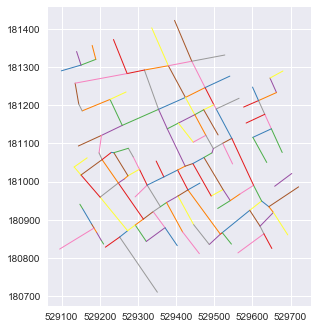

In [3]:
# Load point data
pumps = gpd.read_file(js_path+'Pumps.shp')
# Load building blocks
blocks = gpd.read_file(js_path+'polys.shp')
# Load street network
js = gpd.read_file(js_path+'streets_js.shp')
# Quickly plot the streets
js.plot(cmap='Set1')

And, since it is a full-fledge `GeoDataFrame`, we can also inspect its top rows the same way as with polygons:

In [4]:
js.head()

,Deaths,Deaths_dens,geometry,segIdStr,seg_len
0,0.0,0.000000,"LINESTRING (529521 180866, 529516 180862)",s0-1,6.403124
1,1.0,1.077897,"LINESTRING (529521 180866, 529592.98 180924.53)",s0-2,92.773279
2,0.0,0.000000,"LINESTRING (529521 180866, 529545 180836)",s0-3,38.418745
3,0.0,0.000000,"LINESTRING (529516 180862, 529487 180835)",s1-25,39.623226
4,26.0,18.079549,"LINESTRING (529516 180862, 529431 180978)",s1-27,143.808901


Before we move on to the analytical part, we can also create choropleth maps for line data in very much the same way as we have with polygons. In the following code snippet, we build a choropleth using the Fisher-Jenks classification for the density of cholera deaths in each street segment, and style it by adding a background color, building blocks and the location of the water pumps:

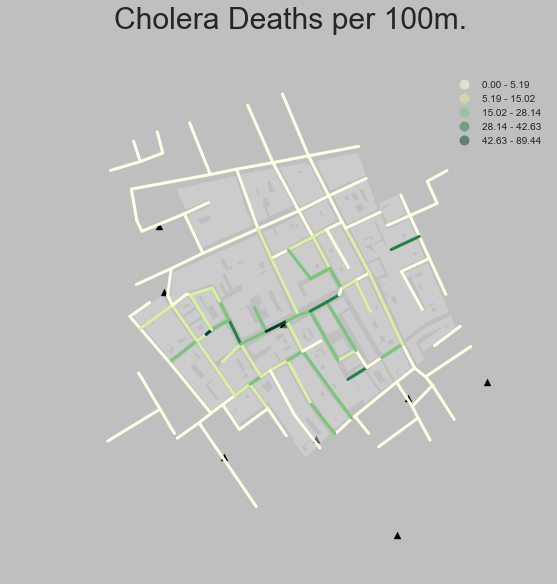

In [5]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot building blocks
blocks.plot(ax=ax, facecolor='0.85', linewidth=0)
# Quantile choropleth of deaths at the street level
js.plot(column='Deaths_dens', scheme='fisher_jenks', ax=ax, \
        cmap='YlGn', legend=True, linewidth=3)
# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Keep axes proportionate
plt.axis('equal')
# Title
f.suptitle('Cholera Deaths per 100m.', size=30)
# Draw
plt.show()

---

**[Optional exercise]**

Create a similar map as above but using a quantile classification and an equal interval one. How do the maps differ? How do you think the distribution of values is for this dataset? Confirm your hunch by generating a density/histogram plot.

---

### Spatial weights matrix

As discused before, a spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. We have seen already many of the conceptual ways in which we can define a spatial weights matrix, such as contiguity, distance-based, or block. Although the examples we have considered so far relate to points and polygons, these ideas can also be applied with spatial networks made of line segments.

For this example, we will show how to build a simple contiguity matrix, which considers two observations as neighbors if they share one edge. In other words, for a street network as in our example, two street segments will be connected if they "touch" each other. Since lines only have one dimension, there is no room for the discussion between "queen" and "rook" criteria, but only one type of contiguity.

Technically speaking, building a contiguity matrix from a spatial network like the streets of London's Soho can be done with `PySAL`, but the route to creating it is slightly different. For this task, instead of the `ps.queen_from_shapefile`, we will use the network module of the library, which reads a line shapefile and creates a network representation of it. Once loaded, a contiguity matrix can be easily created using the `contiguityweights` attribute. To keep things aligned, we rename the IDs of the matrix to match those in the table and, finally, we row-standardize the matrix, which is a standard `ps.W` object, like those we have been working with for the polygon and point cases:

In [6]:
# Load the network
ntw = ps.Network(js_path+'streets_js.shp')
# Create the spatial weights matrix
w = ntw.contiguityweights(graph=False)
# Rename IDs to match those in the `segIdStr` column
w.remap_ids(js['segIdStr'])
# Row standardize the matrix
w.transform = 'R'

('WARNING: ', 's70-90', ' is an island (no neighbors)')


/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: (73, 74)
  warnings.warn("Island id: %s" % str(self.islands[0]))


**Pro-tip**: Note also how, when we create the contiguity weights, we include the argument `graph=False`. This makes sure that we consider each street segment as it is represented in the shapefile, not as represented by the internal graph.

Now, the `w` object we have just created comes from a line shapefile, but it is of the same type of any other one we have created in the past. As such, we can inspect it in the same way. For example, we can check who is a neighbor of observation `s0-1`:

In [7]:
w['s0-1']

{'s0-2': 0.25, 's0-3': 0.25, 's1-25': 0.25, 's1-27': 0.25}

Note how, because we have row-standardize them, the weight given to each of the four neighbors is 0.25 which, all together, sum up to one.

### Spatial lag

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the death density. Remember the spatial lag is the product of the spatial weights matrix and a given variable and that, if $W$ is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

We can calculate the spatial lag for the variable `Deaths_dens` and store it directly in the main table with the following line of code:

In [8]:
js['w_Deaths_dens'] = ps.lag_spatial(w, js['Deaths_dens'])

Let us have a quick look at the resulting variable, as compared to the original one:

In [9]:
js[['segIdStr', 'Deaths_dens', 'w_Deaths_dens']].head()

,segIdStr,Deaths_dens,w_Deaths_dens
0,s0-1,0.000000,4.789361
1,s0-2,1.077897,0.000000
2,s0-3,0.000000,0.538948
3,s1-25,0.000000,6.026516
4,s1-27,18.079549,0.000000


The way to interpret the spatial lag (`w_Deaths_dens`) for say the first observation is as follow: the street segment `s0-1`, which has a density of zero cholera deaths per 100 metres, is surrounded by other streets which, on average, have 4.79 deaths per 100 metres. For the purpose of illustration, we can in fact check this is correct by querying the spatial weights matrix to find out the neighbors of `s0-1`:

In [10]:
w.neighbors['s0-1']

['s0-2', 's0-3', 's1-25', 's1-27']

And then checking their values:

In [11]:
# Note that we first index the table on the index variable
neigh = js.set_index('segIdStr').loc[w.neighbors['s0-1'], 'Deaths_dens']
neigh

segIdStr
s0-2      1.077897
s0-3      0.000000
s1-25     0.000000
s1-27    18.079549
Name: Deaths_dens, dtype: float64

And the average value, which we saw in the spatial lag is 4.79, can be calculated as follows:

In [12]:
neigh.mean()

4.7893612696592509

For some of the techniques we will be seeing below, it makes more sense to operate with the standardized version of a variable, rather than with the raw one. Standardizing means to substract the average value and divide by the standard deviation each observation of the column. This can be done easily with a bit of basic algebra in Python:

In [13]:
js['Deaths_dens_std'] = (js['Deaths_dens'] - js['Deaths_dens'].mean()) / js['Deaths_dens'].std()

Finally, to be able to explore the spatial patterns of the standardized values, also called sometimes $z$ values, we need to create its spatial lag:

In [14]:
js['w_Deaths_dens_std'] = ps.lag_spatial(w, js['Deaths_dens_std'])

## Global Spatial autocorrelation

Global spatial autocorrelation relates to the overall geographical pattern present in the data. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarize it. This summary can be visual or numerical. In this section, we will walk through an example of each of them: the Moran Plot, and Moran's I statistic of spatial autocorrelation.

### Moran Plot

The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python, provided we have standardized the variable and calculated its spatial lag beforehand:

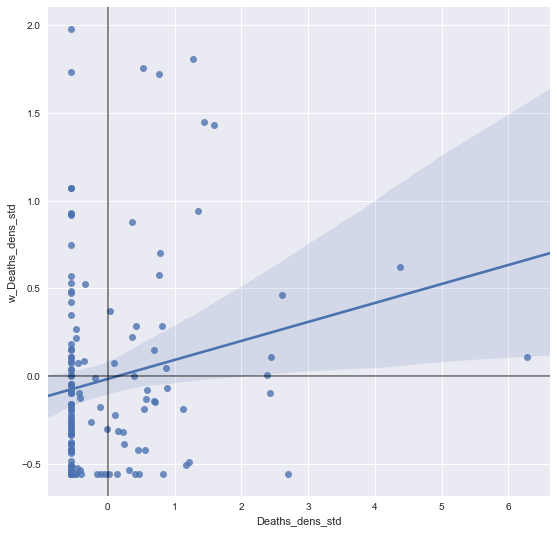

In [15]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_Deaths_dens_std', data=js)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

The figure above displays the relationship between `Deaths_dens_std` and its spatial lag which, because the $W$ that was used is row-standardized, can be interpreted as the average standardized density of cholera deaths in the neighborhood of each observation. In order to guide the interpretation of the plot, a linear fit is also included in the post, together with confidence intervals. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line. Because the line comes from a regression, we can also include a measure of the uncertainty about the fit in the form of confidence intervals (the shaded blue area around the line).

The plot displays a positive relationship between both variables. This is associated with the presence of *positive* spatial autocorrelation: similar values tend to be located close to each other. This means that the *overall trend* is for high values to be close to other high values, and for low values to be surrounded by other low values. This however does not mean that this is only situation in the dataset: there can of course be particular cases where high values are surrounded by low ones, and viceversa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

In the context of the example, this can be interpreted along the lines of: street segments in the dataset show positive spatial autocorrelation in the density of cholera deaths. This means that street segments with a high level of incidents per 100 metres tend to be located adjacent to other street segments also with high number of deaths, an viceversa.

### Moran's I

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I is meant to do. 

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is an even close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In order to calculate Moran's I in our dataset, we can call a specific function in `PySAL` directly:

In [16]:
mi = ps.Moran(js['Deaths_dens'], w)

Note how we do not need to use the standardized version in this context as we will not represent it visually.

The method `ps.Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [17]:
mi.I

0.10902663995497329

The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics?

The specific details of the mechanism to calculate this are beyond the scope of the session, but it is important to know that a small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern that we would expect if the values had been randomly allocated to a particular location.

The most reliable p-value for Moran's I can be found in the attribute `p_sim`:

In [18]:
mi.p_sim

0.048000000000000001

That is just below 5% and, by standard terms, it would be considered statistically significant. Again, a full statistical explanation of what that really means and what its implications are is beyond the discussion in this notebook. But we can quickly ellaborate on its intuition. What that 0.048 (or 4.8%) means is that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 4.8% of them would display a larger (absolute) value than the one we obtain from the real data, and the other 95.2% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the density of cholera deaths is more concentrated than if we were to randomly shuffle the death densities among the Soho streets, hence the statistical significance.

As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively correlated over space. In terms of our initial goal to find evidence for John Snow's hypothesis that cholera was caused by water in a single contaminated pump, this view seems to align: if cholera was contaminated through the air, it should show a pattern over space -arguably a random one, since air is evenly spread over space- that is much less concentrated than if this was caused by an agent (water pump) that is located at a particular point in space.

## Local Spatial autocorrelation

Moran's I is good tool to summarize a dataset into a single value that informs about its degree of *clustering*. However, it is not an appropriate measure to identify areas within the map where specific values are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about *where* the clusters are. For that purpose, we need to use a *local* measure of spatial autocorrelation. Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as *global* measures do. Because of that, they are not good a summarizing a map, but they allow to obtain further insight.

In this session, we will consider [Local Indicators of Spatial Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract) (LISAs), a local counter-part of global measures like Moran's I. At the core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Each of these groups are typically called "quadrants". An illustration of where each of these groups fall into the Moran Plot can be seen below:

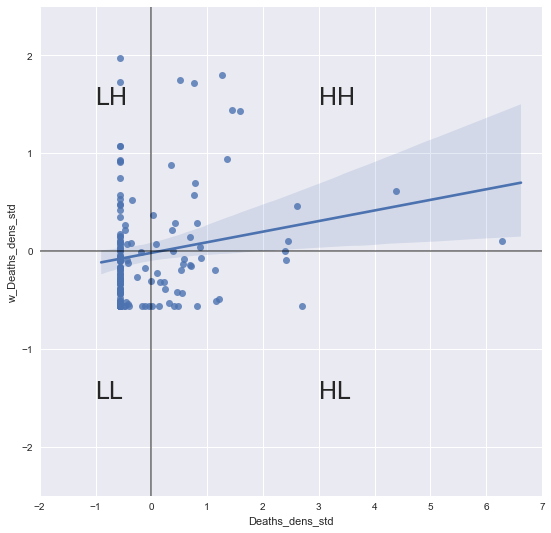

In [19]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_Deaths_dens_std', data=js)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
# Display
plt.show()

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. 

This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide *suggestive* evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`:

In [20]:
lisa = ps.Moran_Local(js['Deaths_dens'].values, w)

/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/pysal/esda/moran.py:835: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


All we need to pass is the variable of interest -density of deaths in this context- and the spatial weights that describes the neighborhood relations between the different observation that make up the dataset.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember that we are calculating a statistic for every sigle observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table, `js`:

In [21]:
# Break observations into significant or not
js['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
js['quadrant'] = lisa.q

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation is satisfies the condition, and `False` otherwise. We can check this is the case:

In [22]:
js['significant'].head()

0    False
1    False
2    False
3    False
4     True
Name: significant, dtype: bool

And the first five p-values can be checked by:

In [23]:
lisa.p_sim[:5]

array([ 0.421,  0.081,  0.269,  0.443,  0.001])

Note how only the last one is smaller than 0.05, as the variable `significant` correctly identified.

Second, the quadrant each observation belongs to. This one is easier as it comes built into the `lisa` object directly:

In [24]:
js['quadrant'].head()

0    3
1    3
2    3
3    3
4    4
Name: quadrant, dtype: int64

The correspondence between the numbers in the variable and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL

With these two elements, `significant` and `quadrant`, we can build a typical LISA cluster map combining the mapping skills with what we have learned about subsetting and querying tables:

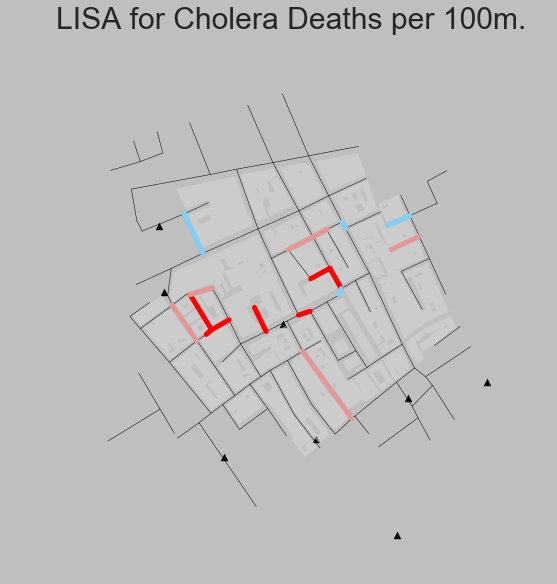

In [25]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot building blocks
blocks.plot(facecolor='0.85', linewidth=0, ax=ax)
# Plot baseline street network
js.plot(color='k', linewidth=0.5, ax=ax)
# Plot HH clusters
hh = js.loc[(js['quadrant']==1) & (js['significant']==True), 'geometry']
hh.plot(ax=ax, color='red', linewidth=5)
# Plot LL clusters
ll = js.loc[(js['quadrant']==3) & (js['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue', linewidth=5)
# Plot LH clusters
lh = js.loc[(js['quadrant']==2) & (js['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4', linewidth=5)
# Plot HL clusters
hl = js.loc[(js['quadrant']==4) & (js['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696', linewidth=5)
# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Style and draw
f.suptitle('LISA for Cholera Deaths per 100m.', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.axis('equal')
plt.show()

The map above displays the streets of the John Snow map of cholera and overlays on top of it the obervations that have been identified by the LISA as clusters or spatial outliers. In bright red, we find those street segments with an unusual concentration of high death density surrounded also by high death density. This corresponds with segments that are close to the contaminated pump, which is also displayed in the center of the map. In light red, we find the first type of *spatial outliers*. These are streets with high density but surrounded by low density. Finally, in light blue we find the other type of spatial outlier: streets with low densities surrounded by other streets with high density.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to find support in the data for John Snow's thesis that cholera deaths were caused by a source that could be traced back to a contaminated water pump. The results seem to large support this view. First, the LISA statistic identifies a few clusters of high densities surrounded by other high densities, discrediting the idea that cholera deaths were not concentrated in specific parts of the street network. Second, the location of all of these HH clusters centers around only one pump, which in turn is the one that ended up being contaminated. 

Of course the results are not entirely clean, they almost never are with real data analysis. Not every single street segment around the pump is identified as a cluster, while we find others that could potentially be linked to a different pump (although when one looks at the location of all clusters the pattern is clear). At this point it is important to remember issues in the data collection and the use of an approximation for the underlying population. Some of that could be at work here. Also, since this is real world data, many other factors that we are not accounting for in this analysis could also be affecting. However, it is important to note that, despite all of those shortcomings, the analysis points into very much the same direction that John Snow concluded more than 150 years ago. What it adds to his original assessment is the power and robustness that comes with statistical inference and does not with visualization only. Some might have objected that, although convincing, there was no statistical evidence behind his original map and hence it could have still been the result of a purely random process in which water had no role in transmitting cholera. Upon the results presented here, such view is much more difficult to sustain.

---

**[Optional exercise]**

Create a similar map as above but display only HH clusters, ignoring the spatial outliers.

---

## Main exercise

Replicate the analysis above for the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a simple choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

## `[Extension]` Spatial autocorrelation interactive visualization

If you are interested in the interactive visualization used in class to demonstrate the concept of spatial autocorrelation, you can find the online version of the notebook, executable directly from the browser and without the need to install anything, on the following link:

> [http://mybinder.org/repo/darribas/int_sp_auto](http://mybinder.org/repo/darribas/int_sp_auto)

---

<a rel="repo" href="https://github.com/darribas/gds17"><img alt="@darribas/gds17" style="border-width:0" src="../../GitHub-Mark.png" /></a>

This notebook, as well as the entire set of materials, code, and data included
in this course are available as an open Github repository available at: [`https://github.com/darribas/gds17`](https://github.com/darribas/gds17)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'17 - Lab 5</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

